# Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import zipfile
import io
import re
import timeit

from math import sqrt, sin, cos, log, pi, e
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

# Change the current folder to the folder where we can find the results
current_folder = !pwd
os.chdir(current_folder[0])

# Retrieving the data
We selected the datasets used in experiments in GP in the last five years of GECCO.

Here are the auxiliary functions used to recover the data.

In [5]:
def synthetic_gen(name, rnd, function, training_gen, test_gen=None):
    print("Generating the \"" + name + "\" dataset")
    training_set = []
    test_set = []
    for i in range(training_gen.n):
        inst = training_gen.generate(rnd)
        training_set.append(inst + [function(*inst)])
    if test_gen:
        for i in range(test_gen.n):
            inst = test_gen.generate(rnd)
            test_set.append(inst + [function(*inst)])
    else:
        test_set = training_set
    return {"training": pd.DataFrame(training_set),
            "test": pd.DataFrame(test_set)}

class U:
    def __init__(self, ini, end, n):
        self.ini = ini
        self.end = end
        self.n = n
    
    def generate(self, rnd):
        return [rnd.uniform(ini, end) for ini, end in zip(self.ini, self.end)]

class E:
    def __init__(self, ini, end, step):
        self.ini = ini
        self.end = end
        self.step = step
        
        mesh = np.meshgrid(*[np.arange(ini, end+step, step) 
                           for ini, end, step in zip(self.ini, self.end, self.step)])
        self.points = [dim.reshape(1,-1)[0] for dim in mesh]
        self.index = 0
        self.n = len(self.points[0])
    
    def generate(self, rnd):
        inst = [self.points[i][self.index] for i in range(len(self.points))]
        self.index += 1
        return inst

def get_data(name, url, rnd=None, pd_sep=',', pd_header=None, pd_skiprows=None, dataset=None):
    print("Reading the \"" + name + "\" dataset")
    if dataset == "BOH":
        from sklearn.datasets import load_boston
        boston = load_boston()
        df = pd.DataFrame(boston['data'])
        df = pd.concat([df, pd.Series(boston['target'])], axis=1)
    elif dataset == "CCP":
        # Get the file object from an url
        r = requests.get(url)
        # Create a ZipFile object from it
        z = zipfile.ZipFile(io.BytesIO(r.content))
        # Read from a xlsx file inside the zip file
        df = pd.read_excel(z.open('CCPP/Folds5x2_pp.xlsx'))
    elif dataset == "CST":
        df = pd.read_excel(url)
    elif dataset == "ENC":
        df = pd.read_excel(url)
        # Drop Y1
        df.drop("Y1", axis=1, inplace=True)
    elif dataset == "ENH":
        df = pd.read_excel(url)
        # Drop Y2
        df.drop("Y2", axis=1, inplace=True)
    elif dataset == "YAC":
        # Get the data as text
        text = requests.get(url).text
        # Split in rows (remove the last line)
        e_re = re.compile("\s*\n\s*")
        rows = e_re.split(text)[:-1]
        e_re = re.compile(" +")
        # Split cells per row
        df = pd.DataFrame([e_re.split(row) for row in rows])
    else:
        df = pd.read_csv(url, header=pd_header, sep=pd_sep, skiprows=pd_skiprows)
        if dataset == "ABA":
            # Get dummy variables for the first column
            df_dummies = pd.get_dummies(df.iloc[:,0])
            # Drop the first column
            df.drop(df.columns[0], axis=1, inplace=True)
            # Concatenate the dummy variables with the data
            df = pd.concat([df_dummies, df], axis=1)
            df = df.sample(500, random_state=rnd, axis=0)
        elif dataset == "CPU":
            # Drop the first two columns
            df.drop(df.columns[[0,1]], axis=1, inplace=True)
        elif dataset == "FFR":
            df.drop(["month", "day"], axis=1, inplace=True)
        elif dataset == "OZO":
            # Imputation (replance NaN's by the mean of the column)
            df.fillna(df.mean(), inplace=True)
    return df.apply(np.float64)


The synthetic data is generated on the run and the real-word datasets are loaded from online resources, with exception of the Ozone dataset, which is loaded from the [mlbench R package](https://cran.r-project.org/web/packages/mlbench/index.html), and the Boston dataset, which is loaded using [Scikit](http://scikit-learn.org/stable/datasets/index.html).

In [6]:
seed = 1234
rnd = np.random.RandomState(seed)
# Loading synthetic datasets
data_synt = {"meier-3": synthetic_gen("Meier-3", rnd, 
                                      lambda x_1,x_2: (x_1**2*x_2**2)/(x_1+x_2), 
                                      U([-1, -1], [1, 1], 50), U([-1, -1], [1, 1], 50)),
            "meier-4": synthetic_gen("Meier-4", rnd, 
                                     lambda x_1,x_2: x_1**5/x_2**3, 
                                     U([-1, -1], [1, 1], 50), U([-1, -1], [1, 1], 50)),
            "nonic": synthetic_gen("Nonic", rnd,
                                   lambda x_1: sum([x_1**i for i in range(1,10)]), 
                                   E([-1], [1], [2/19]), U([-1], [1], 20)),
            "sine": synthetic_gen("Sine", rnd,
                                  lambda x_1: sin(x_1), 
                                  E([0], [6.2], [0.1])),
            "burks": synthetic_gen("Burks", rnd,
                                   lambda x_1: 4*x_1**4 + 3*x_1**3 + 2*x_1**2 + x_1, 
                                   U([-1], [1], 20)),
            "r1": synthetic_gen("R1", rnd,
                                lambda x_1: (x_1+1)**3/(x_1**2-x_1+1), 
                                E([-1], [1], [2/19]), U([-1], [1], 20)),
            "r2": synthetic_gen("R2", rnd,
                                lambda x_1: (x_1**5-3*x_1**3+1)/(x_1**2+1), 
                                E([-1], [1], [2/19]), U([-1], [1], 20)),
            "r3": synthetic_gen("R3", rnd,
                                lambda x_1: (x_1**6+x_1**5)/(x_1**4+x_1**3+x_1**2+x_1+1), 
                                E([-1], [1], [2/19]), U([-1], [1], 20)),
            "poly-10": synthetic_gen("Poly-10", rnd,
                                     lambda x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10: 
                                         x_1*x_2+x_3*x_4+x_5*x_6+x_1*x_7*x_9+x_3*x_6*x_10,
                                     U([0]*10, [1]*10, 330), U([0]*10, [1]*10, 170)),
            "koza-2": synthetic_gen("Koza-2", rnd,
                                    lambda x_1: x_1**5-2*x_1**3+x_1, 
                                    U([-1], [1], 20), U([-1], [1], 20)),
            "koza-3": synthetic_gen("Koza-3", rnd,
                                    lambda x_1: x_1**6-2*x_1**4+x_1**2,
                                    U([-1], [1], 20), U([-1], [1], 20)),
            "korns-1": synthetic_gen("Korns-1", rnd,
                                     lambda x_1, x_2, x_3, x_4, x_5: 1.57+24.3*x_4,
                                     U([-50]*5, [50]*5, 10000), U([-50]*5, [50]*5, 10000)),
            "korns-4": synthetic_gen("Korns-4", rnd,
                                     lambda x_1, x_2, x_3, x_4, x_5: 
                                         -2.3+0.13*sin(x_3),
                                     U([-50]*5, [50]*5, 10000), U([-50]*5, [50]*5, 10000)),
            "korns-7": synthetic_gen("Korns-7", rnd,
                                     lambda x_1, x_2, x_3, x_4, x_5: 
                                         213.80940889*(1-e**(-0.54723748542*x_1)),
                                     U([-50]*5, [50]*5, 10000), U([-50]*5, [50]*5, 10000)),
            "korns-11": synthetic_gen("Korns-11", rnd,
                                     lambda x_1, x_2, x_3, x_4, x_5: 
                                         6.87+11*cos(7.23*x_1**3),
                                     U([-50]*5, [50]*5, 10000), U([-50]*5, [50]*5, 10000)),
            "korns-12": synthetic_gen("Korns-12", rnd,
                                     lambda x_1, x_2, x_3, x_4, x_5: 
                                         2-2.1*cos(9.8*x_1)*sin(1.3*x_5),
                                     U([-50]*5, [50]*5, 10000), U([-50]*5, [50]*5, 10000)),
            "vladislavleva-1": synthetic_gen("Vladislavleva-1", rnd,
                                             lambda x_1, x_2: 
                                                 e**(-(x_1-1)**2)/(1.2+(x_2-2.5)**2),
                                             U([0.3]*2, [4]*2, 100), E([-0.2]*2, [4.2]*2, [0.1]*2)),
            "vladislavleva-2": synthetic_gen("Vladislavleva-2", rnd,
                                             lambda x_1: 
                                                 e**(-x_1)*x_1**3*(cos(x_1)*sin(x_1))*(cos(x_1)*sin(x_1)**2-1),
                                             E([0.05], [10], [0.1]), E([-0.5], [10.5], [0.05])),
            "vladislavleva-3": synthetic_gen("Vladislavleva-3", rnd,
                                             lambda x_1, x_2: 
                                                 e**(-x_1)*x_1**3*(cos(x_1)*sin(x_1))*(cos(x_1)*sin(x_1)**2-1)*(x_2-5),
                                             E([0.05]*2, [10, 10.05], [0.1, 2]), E([-0.5]*2, [10.5]*2, [0.05, 0.5])),
            "vladislavleva-4": synthetic_gen("Vladislavleva-4", rnd,
                                             lambda x_1, x_2, x_3, x_4, x_5: 
                                                 10/(5+(x_1-3)**2+(x_2-3)**2+(x_3-3)**2+(x_4-3)**2+(x_5-3)**2),
                                             U([0.05]*5, [6.05]*5, 1024), U([-0.25]*5, [6.35]*5, 5000)),
            "vladislavleva-5": synthetic_gen("Vladislavleva-5", rnd,
                                             lambda x_1, x_2, x_3: 
                                                 30*(x_1-1)*(x_3-1)/((x_1-10)*x_2**2),
                                             U([0.05, 1, 0.05], [2]*3, 300), 
                                             E([-0.05, 0.95, -0.05], [2.1, 2.05, 2.1], [0.15, 0.1, 0.15])),
            "vladislavleva-6": synthetic_gen("Vladislavleva-6", rnd,
                                             lambda x_1, x_2: 6*sin(x_1)*cos(x_2),
                                             U([0.1]*2, [5.9]*5, 30), 
                                             E([-0.05]*2, [6.05]*2, [0.02]*2)),
            "vladislavleva-7": synthetic_gen("Vladislavleva-7", rnd,
                                             lambda x_1, x_2: 
                                                 (x_1-3)*(x_2-3)+2*sin((x_1-4)*(x_2-4)),
                                             U([0.05]*2, [6.05]*2, 300), U([-0.25]*2, [6.35]*2, 1000)),
            "vladislavleva-8": synthetic_gen("Vladislavleva-8", rnd,
                                             lambda x_1, x_2: 
                                                 ((x_1-3)**4+(x_2-3)**3-(x_2-3))/((x_2-2)**4+10),
                                             U([0.05]*2, [6.05]*2, 50), E([-0.25]*2, [6.35]*2, [0.2]*2)),
            "pagie-1": synthetic_gen("Pagie-1", rnd,
                                     lambda x_1, x_2: 1/(1+x_1**(-4))+1/(1+x_2**(-4)),
                                     E([-5]*2, [5]*2, [0.4]*2)),
            "keijzer-1": synthetic_gen("Keijzer-1", rnd,
                                       lambda x_1: 
                                           0.3*x_1*sin(2*pi*x_1),
                                       E([-1], [1], [0.1]),
                                       E([-1], [1], [0.001])),
            "keijzer-2": synthetic_gen("Keijzer-2", rnd,
                                       lambda x_1: 
                                           0.3*x_1*sin(2*pi*x_1),
                                       E([-2], [2], [0.1]),
                                       E([-2], [2], [0.001])),
            "keijzer-3": synthetic_gen("Keijzer-3", rnd,
                                       lambda x_1: 
                                           0.3*x_1*sin(2*pi*x_1),
                                       E([-3], [3], [0.1]),
                                       E([-3], [3], [0.001])),
            "keijzer-4": synthetic_gen("Keijzer-4", rnd,
                                       lambda x_1: 
                                           x_1**3*e**(-x_1)*cos(x_1)*sin(x_1)*(sin(x_1)**2*cos(x_1)-1),
                                       E([0], [10], [0.05]),
                                       E([0.05], [10.05], [0.05])),
            "keijzer-5": synthetic_gen("Keijzer-5", rnd,
                                       lambda x_1, x_2, x_3: 30*x_1*x_3/((x_1-10)*x_2**2),
                                       U([-1, 1, -1], [1,2,1], 1000),
                                       U([-1, 1, -1], [1,2,1], 10000)),
            "keijzer-6": synthetic_gen("Keijzer-6", rnd,
                                       lambda x_1: sum([1/i for i in range(1, x_1+1)]),
                                       E([1], [50], [1]),
                                       E([1], [120], [1])),
            "keijzer-7": synthetic_gen("Keijzer-7", rnd,
                                       lambda x_1: log(x_1),
                                       E([1], [100], [1]),
                                       E([1], [100], [0.1])),
            "keijzer-8": synthetic_gen("Keijzer-8", rnd,
                                       lambda x_1: sqrt(x_1),
                                       E([0], [100], [1]),
                                       E([0], [100], [0.1])),
            "keijzer-9": synthetic_gen("Keijzer-9", rnd,
                                       lambda x_1: log(x_1+sqrt(x_1**2+1)),
                                       E([0], [100], [1]),
                                       E([0], [100], [0.1])),
            "keijzer-10": synthetic_gen("Keijzer-10", rnd,
                                       lambda x_1, x_2: x_1**x_2,
                                       U([0]*2, [1]*2, 100),
                                       E([0]*2, [1]*2, [0.01]*2)),
            "keijzer-11": synthetic_gen("Keijzer-11", rnd,
                                       lambda x_1, x_2: x_1*x_2+sin((x_1-1)*(x_2-1)),
                                       U([-3]*2, [3]*2, 20),
                                       E([-3]*2, [3]*2, [0.01]*2)),
            "keijzer-12": synthetic_gen("Keijzer-12", rnd,
                                       lambda x_1, x_2: x_1**4-x_1**3+(x_2**2/2)-x_2,
                                       U([-3]*2, [3]*2, 20),
                                       E([-3]*2, [3]*2, [0.01]*2)),
            "keijzer-13": synthetic_gen("Keijzer-13", rnd,
                                       lambda x_1, x_2: 6*sin(x_1)*cos(x_2),
                                       U([-3]*2, [3]*2, 20),
                                       E([-3]*2, [3]*2, [0.01]*2)),
            "keijzer-14": synthetic_gen("Keijzer-14", rnd,
                                       lambda x_1, x_2: 8/(2+x_1**2+x_2**2),
                                       U([-3]*2, [3]*2, 20),
                                       E([-3]*2, [3]*2, [0.01]*2)),
            "keijzer-15": synthetic_gen("Keijzer-15", rnd,
                                       lambda x_1, x_2: (x_1**3/5)+(x_2**3/2)-x_2-x_1,
                                       U([-3]*2, [3]*2, 20),
                                       E([-3]*2, [3]*2, [0.01]*2)),
            "nguyen-1": synthetic_gen("Nguyen-1", rnd,
                                       lambda x_1: x_1**3+x_1**2+x_1,
                                       U([-1], [1], 20),
                                       U([-1], [1], 20)),
            "nguyen-2": synthetic_gen("Nguyen-2", rnd,
                                       lambda x_1: x_1**4+x_1**3+x_1**2+x_1,
                                       U([-1], [1], 20),
                                       U([-1], [1], 20)),
            "nguyen-3": synthetic_gen("Nguyen-3", rnd,
                                       lambda x_1: x_1**5+x_1**4+x_1**3+x_1**2+x_1,
                                       U([-1], [1], 20),
                                       U([-1], [1], 20)),
            "nguyen-4": synthetic_gen("Nguyen-4", rnd,
                                       lambda x_1: x_1**6+x_1**5+x_1**4+x_1**3+x_1**2+x_1,
                                       U([-1], [1], 20),
                                       U([-1], [1], 20)),
            "nguyen-5": synthetic_gen("Nguyen-5", rnd,
                                       lambda x_1: sin(x_1**2)*cos(x_1)-1,
                                       U([-1], [1], 20),
                                       U([-1], [1], 20)),
            "nguyen-6": synthetic_gen("Nguyen-6", rnd,
                                       lambda x_1: sin(x_1)+sin(x_1+x_1**2),
                                       U([-1], [1], 20),
                                       U([-1], [1], 20)),
            "nguyen-7": synthetic_gen("Nguyen-7", rnd,
                                       lambda x_1: log(x_1+1)+log(x_1**2+1),
                                       U([0], [2], 20),
                                       U([0], [2], 20)),
            "nguyen-8": synthetic_gen("Nguyen-8", rnd,
                                       lambda x_1: sqrt(x_1),
                                       U([0], [4], 20),
                                       U([0], [4], 20)),
            "nguyen-9": synthetic_gen("Nguyen-9", rnd,
                                       lambda x_1, x_2: sin(x_1)+sin(x_2**2),
                                       U([-1]*2, [1]*2, 100),
                                       U([-1]*2, [1]*2, 100)),
            "nguyen-10": synthetic_gen("Nguyen-10", rnd,
                                       lambda x_1, x_2: 2*sin(x_1)*cos(x_2),
                                       U([-1]*2, [1]*2, 100),
                                       U([-1]*2, [1]*2, 100))
            }

seed = 4567
rnd = np.random.RandomState(seed)
# Loading real-world datasets
data_real = {"abalone": get_data('Abalone', 
                                 'https://archive.ics.uci.edu/ml/'
                                 'machine-learning-databases/abalone/abalone.data',
                                 rnd=rnd, dataset='ABA'),
            "airfoil": get_data('Airfoil',
                                'https://archive.ics.uci.edu/ml/'
                                'machine-learning-databases/00291/airfoil_self_noise.dat',
                                pd_sep="\t"),
            "boston": get_data('Boston', "", dataset="BOH"),
            "combined-cycle": get_data('Combined-cycle', 
                                       'https://archive.ics.uci.edu/ml/'
                                       'machine-learning-databases/00294/CCPP.zip',
                                       dataset="CCP"),
            "computer-hardware": get_data('Computer-hardware', 
                                          'https://archive.ics.uci.edu/ml/'
                                          'machine-learning-databases/cpu-performance/machine.data',
                                          dataset="CPU"),
            "concrete-strength": get_data('Concrete-strength', 
                                          'https://archive.ics.uci.edu/ml/'
                                          'machine-learning-databases/concrete/compressive/Concrete_Data.xls',
                                          dataset="CST"),
            "energy-cooling": get_data('Energy-cooling', 
                                       'http://archive.ics.uci.edu/ml/'
                                       'machine-learning-databases/00242/ENB2012_data.xlsx',
                                       dataset="ENC"),
            "energy-heating": get_data('Energy-heating', 
                                       'http://archive.ics.uci.edu/ml/'
                                       'machine-learning-databases/00242/ENB2012_data.xlsx',
                                       dataset="ENH"),
            "forest-fire": get_data('Forest-fire', 
                                    'https://archive.ics.uci.edu/ml/'
                                    'machine-learning-databases/forest-fires/forestfires.csv',
                                    pd_header='infer', dataset="FFR"),
            "ozone": get_data('Ozone', './data/ozone.data', dataset="OZO"),
            "wine-quality-red": get_data('Wine-quality-red', 
                                         'https://archive.ics.uci.edu/ml/'
                                         'machine-learning-databases/wine-quality/winequality-red.csv',
                                         pd_header='infer', pd_sep=';'),
            "wine-quality-white": get_data('Wine-quality-white', 
                                           'https://archive.ics.uci.edu/ml/'
                                           'machine-learning-databases/wine-quality/winequality-white.csv', 
                                           pd_header='infer', pd_sep=';'),
            "yacht": get_data('Yacht', 'https://archive.ics.uci.edu/ml/'
                              'machine-learning-databases/00243/yacht_hydrodynamics.data', dataset="YAC")
            }

Generating the "Meier-3" dataset
Generating the "Meier-4" dataset
Generating the "Nonic" dataset
Generating the "Sine" dataset
Generating the "Burks" dataset
Generating the "R1" dataset
Generating the "R2" dataset
Generating the "R3" dataset
Generating the "Poly-10" dataset
Generating the "Koza-2" dataset
Generating the "Koza-3" dataset
Generating the "Korns-1" dataset
Generating the "Korns-4" dataset
Generating the "Korns-7" dataset
Generating the "Korns-11" dataset
Generating the "Korns-12" dataset
Generating the "Vladislavleva-1" dataset
Generating the "Vladislavleva-2" dataset
Generating the "Vladislavleva-3" dataset
Generating the "Vladislavleva-4" dataset
Generating the "Vladislavleva-5" dataset
Generating the "Vladislavleva-6" dataset
Generating the "Vladislavleva-7" dataset
Generating the "Vladislavleva-8" dataset
Generating the "Pagie-1" dataset
Generating the "Keijzer-1" dataset
Generating the "Keijzer-2" dataset
Generating the "Keijzer-3" dataset
Generating the "Keijzer-4" d

# Analyzing  GP performance on the datasets
## Analysis pre-running: Comparing function times (used by GP)
Just to have an idea of the time spent by functions (from a possible function set) inside GP. Notice that we analyzed the functions as they are implemented by `gplearn`.

In [6]:
fmt = "{:<17}{:.4f}"
print(fmt.format("Sin time:",
                 timeit.timeit(stmt="[np.sin(x) for x in X]", 
                                      setup="import numpy as np;"
                                      "X = np.random.rand(1,1000)", 
                                      number = 10000)))
print(fmt.format("Cos time:", 
                 timeit.timeit(stmt="[np.cos(x) for x in X]", 
                                      setup="import numpy as np;"
                                      "X = np.random.rand(1,1000)", 
                                      number = 10000)))
print(fmt.format("Log time:", 
                 timeit.timeit(stmt="[_protected_log(x) for x in X]", 
                                      setup="from gplearn.functions import _protected_log;"
                                      "import numpy as np;"
                                      "X = np.random.rand(1,1000)", 
                                      number = 10000)))
print(fmt.format("Sqrt time:", 
                 timeit.timeit(stmt="[_protected_sqrt(x) for x in X]", 
                                      setup="from gplearn.functions import _protected_sqrt;"
                                      "import numpy as np;"
                                      "X = np.random.rand(1,1000)", 
                                      number = 10000)))
print(fmt.format("Prot. div time:", 
                 timeit.timeit(stmt="[_protected_division(x,y) for x,y in zip(X,Y)]", 
                                      setup="from gplearn.functions import _protected_division;"
                                      "import numpy as np;"
                                      "X = np.random.rand(1,1000);"
                                      "Y = np.random.rand(1,1000);", 
                                      number = 10000)))
print(fmt.format("AQ time:", 
                 timeit.timeit(stmt="[np.divide(x, np.sqrt(1+y**2)) for x,y in zip(X,Y)]", 
                                      setup="from gplearn.functions import _protected_division;"
                                      "import numpy as np;"
                                      "X = np.random.rand(1,1000);"
                                      "Y = np.random.rand(1,1000);", 
                                      number = 10000)))
print(fmt.format("Mul time:", 
                 timeit.timeit(stmt="[np.multiply(x,y) for x,y in zip(X,Y)]", 
                                      setup="import numpy as np;"
                                      "X = np.random.rand(1,1000);"
                                      "Y = np.random.rand(1,1000);", 
                                      number = 10000)))
print(fmt.format("Sub time:", 
                 timeit.timeit(stmt="[np.subtract(x,y) for x,y in zip(X,Y)]", 
                                      setup="import numpy as np;"
                                      "X = np.random.rand(1,1000);"
                                      "Y = np.random.rand(1,1000);", 
                                      number = 10000)))
print(fmt.format("Add time:",
                 timeit.timeit(stmt="[np.add(x,y) for x,y in zip(X,Y)]", 
                                      setup="import numpy as np;"
                                      "X = np.random.rand(1,1000);"
                                      "Y = np.random.rand(1,1000);", 
                                      number = 10000)))

Sin time:        0.2214
Cos time:        0.2137
Log time:        0.6519
Sqrt time:       0.0840
Prot. div time:  0.3673
AQ time:         0.1871
Mul time:        0.0929
Sub time:        0.0544
Add time:        0.0565


## gplearn: Configuration
`gplearn` is Python library for GP, compatible with Scikit learn. We had to specify the Analytic Quotient function manually before the evolution and the parameters used by GP are hard-coded in the function `run_gp`.

In [ ]:
def _aq(x1, x2):
    return np.divide(x1, np.sqrt(1 + x2**2))   

aq = make_function(function=_aq,
                   name='aq',
                   arity=2)

def run_gp(training, test, rnd=None):
    # Normalization constant used to compute the normalized RMSE
    norm_const = np.sqrt(training.shape[0]/(training.shape[0]-1))/training.iloc[:,-1].std()
    
    # Genetic programming instance used to perform symbolic regression in the datasets
    function_set = ['add', 'sub', 'mul', aq, 'sqrt', 'sin']
    gp_param = {'population_size': 1000,
                  'generations': 50, 
                  'stopping_criteria': 0.00,
                  'const_range': (-1,1),
                  'init_depth': (2,6),
                  'init_method': 'half and half',
                  'metric': make_fitness(function=lambda y, y_pred, w:
                      np.sqrt(np.average(((y_pred - y) ** 2), weights=w)) * norm_const,
                                           greater_is_better=False),
                  'tournament_size': 10,
                  'p_crossover': 0.85, 
                  'function_set': function_set,
                  'p_subtree_mutation': 0.05,
                  'p_hoist_mutation': 0.05, 
                  'p_point_mutation': 0.05,
                  'max_samples': 1, 
                  'verbose': 0,
                  'parsimony_coefficient': 0.001, 
                  'random_state': rnd,
                  'n_jobs': 1}
    est_gp = SymbolicRegressor(**gp_param)
    est_gp.fit(training.iloc[:,:-1], training.iloc[:,-1])
    
    #norm_const = np.sqrt(training.shape[0]/(training.shape[0]-1))/training.iloc[:,-1].std()
    stats = {'size': est_gp._program.length_,
             'tr_rmse': est_gp._program.raw_fitness_ / norm_const,
             'tr_nrmse': est_gp._program.raw_fitness_}
    y_est = est_gp.predict(test.iloc[:,:-1])
    rmse = np.sqrt(np.average((y_est - test.iloc[:,-1]) ** 2))
    norm_const = np.sqrt(test.shape[0]/(test.shape[0]-1))/test.iloc[:,-1].std()
    
    stats['ts_rmse'] = rmse
    stats['ts_nrmse'] = rmse * norm_const
    
    return stats

We implemented the experiments so that they run in parallel, taking advantage of multi-core processors.

In [ ]:
def evaluate(dataset_lst, n_jobs=None, n_rep=30, cv=None):
    stats = {}
    experiments = []
    seed = 1234
    rnd = np.random.RandomState(seed)
    kf = KFold(n_splits=cv, shuffle=True, random_state=rnd)
    
    for data_name, data_points in dataset_lst.items():
        stats[data_name] = {}
        # Reset the pseudo-random number generator for each dataset (used by GP)
        rnd = np.random.RandomState(seed)
        
        if cv is not None: 
            partitions = list(kf.split(data_points))
        
        for i in range(n_rep):
            if cv is not None: 
                training = data_points.iloc[partitions[i % cv][0],:]
                test = data_points.iloc[partitions[i % cv][1],:]
            else:
                training = data_points['training']
                test = data_points['test']
            experiments.append([data_name, i+1, training, test, rnd.randint(10**6)])
    if not n_jobs or n_jobs > 1:    
        with Pool(processes=n_jobs) as pool:
            for exec_stats in pool.imap(worker, experiments):
                data_name = exec_stats[0]
                for stats_name, stats_value in exec_stats[1].items():
                    if stats_name not in stats[data_name]:
                        stats[data_name][stats_name] = []
                    stats[data_name][stats_name].append(stats_value)
    else:
        for experiment in experiments:
            exec_stats = worker(experiment)
            data_name = exec_stats[0]
            for stats_name, stats_value in exec_stats[1].items():
                if stats_name not in stats[data_name]:
                    stats[data_name][stats_name] = []
                stats[data_name][stats_name].append(stats_value)
    return stats

def worker(param):
    print("Dataset \"" + param[0] + "\", exec.", param[1])
    return [param[0], run_gp(training=param[2], test=param[3], rnd=param[4])]

def write_stats(stats_dict, path='./performace_metrics/'):
    """Write statistics returned by worker/run_gp methods.

    Extended description of function.

    Parameters
    ----------
    stats_dict : dict
        A dictionary containing results from different datasets. The format is
        in the form stats_dict['data_set_name']['statistics_name']
    arg2 : str
        Description of arg2

    Returns
    -------
    bool
        Description of return value
    """
    for key, data in stats_dict.items():
        df = pd.DataFrame(data)
        df.to_csv(path + key + '.csv')

## Running GP for each dataset
This stage should take a few hours. That is why the results are saved in a local folder future accesses.

In [ ]:
stats_synt = evaluate(data_synt, n_rep = 30)
write_stats(stats_synt)

# The real-word dataset is evaluated using cross-validation
stats_real = evaluate(data_real, n_rep = 30, cv = 5)
write_stats(stats_real)

# Extracting Meta-Features

In [2]:
# Geta data from file
names_synt = ['vladislavleva-8', 'vladislavleva-1', 'koza-3', 'keijzer-6', 'koza-2', 
              'nguyen-4', 'vladislavleva-2', 'keijzer-1', 'r2', 'nonic', 'korns-1', 
              'meier-3', 'nguyen-9', 'keijzer-9', 'korns-7', 'nguyen-5', 'nguyen-6', 
              'nguyen-2', 'sine', 'keijzer-15', 'nguyen-1', 'vladislavleva-4', 
              'vladislavleva-6', 'keijzer-2', 'nguyen-7', 'poly-10', 'nguyen-10', 
              'keijzer-10', 'keijzer-8', 'meier-4', 'keijzer-12', 'nguyen-8', 
              'keijzer-13', 'keijzer-14', 'vladislavleva-5', 'burks', 'keijzer-7', 
              'r3', 'keijzer-4', 'keijzer-5', 'korns-11', 'r1', 'vladislavleva-3', 
              'korns-4', 'korns-12', 'keijzer-11', 'vladislavleva-7', 'keijzer-3', 
              'nguyen-3', 'pagie-1']

names_real = ['boston', 'concrete-strength', 'energy-cooling', 'forest-fire', 
              'combined-cycle', 'ozone', 'energy-heating', 'abalone', 'airfoil', 
              'yacht', 'computer-hardware', 'wine-quality-red', 'wine-quality-white']

data_synt = {}
data_real = {}
for k in names_synt:
    print('Loading the ' + k + ' dataset')
    data_synt[k] = {'training': pd.read_csv('data/' + k + '_tr.csv'),
                    'test': pd.read_csv('data/' + k + '_ts.csv')
                    }

for k in names_real:
    print('Loading the ' + k + ' dataset')
    data_real[k] = pd.read_csv('data/' + k + '.csv')


Loading the vladislavleva-8 dataset
Loading the vladislavleva-1 dataset
Loading the koza-3 dataset
Loading the keijzer-6 dataset
Loading the koza-2 dataset
Loading the nguyen-4 dataset
Loading the vladislavleva-2 dataset
Loading the keijzer-1 dataset
Loading the r2 dataset
Loading the nonic dataset
Loading the korns-1 dataset
Loading the meier-3 dataset
Loading the nguyen-9 dataset
Loading the keijzer-9 dataset
Loading the korns-7 dataset
Loading the nguyen-5 dataset
Loading the nguyen-6 dataset
Loading the nguyen-2 dataset
Loading the sine dataset
Loading the keijzer-15 dataset
Loading the nguyen-1 dataset
Loading the vladislavleva-4 dataset
Loading the vladislavleva-6 dataset
Loading the keijzer-2 dataset
Loading the nguyen-7 dataset
Loading the poly-10 dataset
Loading the nguyen-10 dataset
Loading the keijzer-10 dataset
Loading the keijzer-8 dataset
Loading the meier-4 dataset
Loading the keijzer-12 dataset
Loading the nguyen-8 dataset
Loading the keijzer-13 dataset
Loading the keij

In [3]:
def get_meta_data(data_set_name, training, test):
    if not isinstance(training, (list, tuple)):
        training = [training]
    if not isinstance(test, (list, tuple)):
        test = [test]
        
    meta_data = {}
    meta_data['N. instances (TR)'] = np.mean([fold.shape[0] for fold in training])
    meta_data['N. features (TR)'] = np.mean([fold.shape[1] - 1 for fold in training])
    meta_data['Target std (TR)'] =  np.mean([fold.iloc[:,-1].std() for fold in training])
    meta_data['Target skewness (TR)'] = np.mean([fold.iloc[:,-1].skew() for fold in training])
    training_corr = [fold.corr() for fold in training]
    meta_data['Mean absolute correlation attribute-target (TR)'] = np.mean([fold_cor.iloc[-1, :-1].abs() for fold_cor in training_corr])
    
    meta_data['N. instances (TS)'] = np.mean([fold.shape[0] for fold in test])
    meta_data['Target std (TS)'] = np.mean([fold.iloc[:,-1].std() for fold in test])
    meta_data['Target skewness (TS)'] = np.mean([fold.iloc[:,-1].skew() for fold in test])
    test_corr = [fold.corr() for fold in test]
    meta_data['Mean absolute correlation attribute-target (TS)'] = np.mean([fold_cor.iloc[-1, :-1].abs() for fold_cor in test_corr])
    
    gp_output = pd.read_csv('performace_metrics/' + data_set_name + '.csv', index_col=0)
    meta_data['Median NRMSE  (TR)'] = gp_output['tr_nrmse'].median()
    meta_data['Median NRMSE (TS)'] = gp_output['ts_nrmse'].median()
    meta_data['Function size'] = gp_output['size'].median()
    return meta_data

def get_cross_validation_sets(data_points, kfold, cv=5):
    training = []
    test = []
    partitions = list(kf.split(data_points))
    for i in range(cv):
        training.append(data_points.iloc[partitions[i][0],:])
        test.append(data_points.iloc[partitions[i][1],:])
    return training, test

seed = 1234
rnd = np.random.RandomState(seed)
kf = KFold(n_splits=5, shuffle=True, random_state=rnd)

meta_info = {}
for key, data in data_real.items():
    training, test = get_cross_validation_sets(data, kf)
    meta_info[key] = get_meta_data(key, training, test)
    meta_info[key]['Nature'] = 'Real'

for key, data in data_synt.items():
    meta_info[key] = get_meta_data(key, data['training'], data['test'])
    meta_info[key]['Nature'] = 'Synthetic'

meta_info = pd.DataFrame(meta_info).transpose()
# Impute NaN's with 0 (NaN's appear when a feature has no variation)
meta_info['Mean absolute correlation attribute-target (TR)'].fillna(value = 0, inplace = True)
meta_info['Mean absolute correlation attribute-target (TS)'].fillna(value = 0, inplace = True)
# Cast the columns to numeric types
for k in meta_info.keys():
    if k != 'Nature':
        meta_info[k] = pd.to_numeric(meta_info[k])

In [4]:
from sklearn.ensemble import RandomForestRegressor

X = meta_info.drop(['Median NRMSE  (TR)', 'Function size', 
                    'Nature', 'Median NRMSE (TS)'], axis = 1)
y = meta_info['Median NRMSE (TS)']

rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X, y)
feat_importance = pd.Series(rf.feature_importances_, X.columns.values)

print(feat_importance)

# Given the infomation returned by the RF, we will drop the feature 'N. instances (TS)' 
#meta_info.drop(['N. instances (TS)'], axis = 1, inplace = True)
#X.drop(['N. instances (TS)'], axis = 1, inplace = True)

Mean absolute correlation attribute-target (TR)    0.000000
Mean absolute correlation attribute-target (TS)    0.048950
N. features (TR)                                   0.262492
N. instances (TR)                                  0.106870
N. instances (TS)                                  0.010255
Target skewness (TR)                               0.449254
Target skewness (TS)                               0.050258
Target std (TR)                                    0.014031
Target std (TS)                                    0.057891
dtype: float64


In [5]:
plot_keys = list(meta_info.keys())
[plot_keys.remove(k) for k in ('Median NRMSE  (TR)', 'Nature', 'Function size')];

sm = cm.ScalarMappable(cmap=cm.get_cmap('RdYlBu'))
sm.set_array(meta_info['Median NRMSE (TS)'])

colors = sm.to_rgba(meta_info['Median NRMSE (TS)'])
markers = meta_info['Nature'].replace(['Real', 'Synthetic'], ['o', '^'])

for i in range(len(plot_keys)):   
    for j in range(i+1, len(plot_keys)):
        markers = meta_info['Nature'].replace(['Real', 'Synthetic'], ['o', '^'])
        
        for k in range(meta_info.shape[0]):
            plt.scatter(meta_info[plot_keys[i]][k],
                        meta_info[plot_keys[j]][k], 
                        c = colors[k],
                        marker = markers[k],
                        linewidth=0.2)
        
        plt.xlabel(plot_keys[i])
        plt.ylabel(plot_keys[j])
        plt.colorbar(sm)
        
        plt.savefig('plots/' + plot_keys[i] + ' VS ' + plot_keys[j] + '.pdf', 
                    bbox_inches="tight")
        plt.close()

In [6]:
# Ploting the distribution of the meta features
for k in plot_keys:
    #meta_info[k].plot(kind='hist', bins=25, alpha=0.5, color='blue')
    df_aux = pd.DataFrame({'Real': meta_info[meta_info['Nature'] == 'Real'][k], 'Synthetic': meta_info[meta_info['Nature'] == 'Synthetic'][k]}).plot(kind='hist', bins=25, stacked=True)
    plt.title(k)
    plt.savefig('plots/Hist. ' + k + '.pdf', 
                bbox_inches="tight")
    plt.close()

In [ ]:
std_scale = StandardScaler().fit(X)
X_norm = std_scale.transform(X)

pca = PCA(n_components=2)
X_norm_2d = pca.fit_transform(X_norm)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for i in range(meta_info.shape[0]):    
    ax.scatter(X_norm_2d[i][0], 
                X_norm_2d[i][1], 
                y[i],
                c=colors[i],
                edgecolors='black',
                marker = markers[i],
                linewidth='0.2')
lr = LinearRegression()
lr.fit(X_norm_2d, y)

x_surf = np.linspace(-3.5, 12.5, 20)                # generate a mesh
y_surf = np.linspace(-3, 4.5, 20)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
new_X = [[x_surf[i,j], y_surf[i,j]] for i in range(20) for j in range(20)]
new_y = lr.predict(new_X)

ax.plot_surface(x_surf, y_surf,
                new_y.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4,
                linewidth=0.2, edgecolors='black')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Median NRMSE (TS)')
ax.view_init(elev=9, azim=-61)

plt.colorbar(sm)
plt.savefig('plots/pca_lr.pdf', bbox_inches="tight")

In [23]:
print(min([x[0] for x in X_norm_2d]), max([x[0] for x in X_norm_2d]))
print(min([x[1] for x in X_norm_2d]), max([x[1] for x in X_norm_2d]))

-3.0241382315765692 12.242250848311903
-2.5088121721998102 4.213378288558671


400

## Regression plots

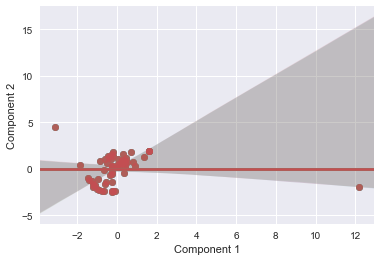

In [51]:
sns.set(color_codes=True)
markers = ["o", "^"]

plot_data = pd.DataFrame(index=meta_info.index.values)

plot_data["Nature"] = meta_info['Nature'].values
plot_data["Component 1"] = X_norm_2d[:,0]
plot_data["Component 2"] = X_norm_2d[:,1]

sns_plot = sns.regplot(x="Component 1", 
                       y="Component 2", 
                       data=plot_data, )
                       #aspect=1,
                       #size=10);
#sns_plot.savefig("regplot.png")

plt.show()

In [ ]:
sns_plot = sns.lmplot(x="Component 1", y="Component 2", hue="Nature", col="Nature", data=plot_data, markers=markers, size=8, aspect=1, palette="Set1");
sns_plot.savefig("regplot_by_nature.png")